In [1]:
# Import libraries
%load_ext autoreload
%autoreload 2

# from pulse_lib.pickle_parse import *
# from pulse_lib.phase_calibration import *
from pulse_lib.calibrate_phase_v2 import *

from qick import *
import Pyro4
import pickle
%pylab inline

# Pyro communicates with board
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# Static IP proxy
ns_host = "192.168.2.99"
ns_port = 8888
proxy_name = "myqick"

# QICK object
ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
out_chs = [0,1]
print(soccfg)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib

QICK configuration:

	Board: RFSoC4x2

	Software version: 0.2.267
	Firmware timestamp: Wed Sep  6 18:49:29 2023

	Global clocks (MHz): tProcessor 409.600, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D
	1:	axis_readout_v2 - configured by PYNQ


In [2]:
# TODO: Make this a user-defined numpy array
# f0_start=100
# f0_step=1
# expts=100
# expts=1

f0_v = np.arange(21, 3001, 1)

# f0_v = np.arange(0,expts)*f0_step+f0_start
f0_v = soccfg.adcfreq(f0_v, gen_ch=0, ro_ch=0)

In [3]:
# TODO: Remove unnecessary function calls
# TODO: Move outside of notebook

config={"out_ch":out_chs,
        "reps":1, # --Fixed
        "res_phase":soccfg.deg2reg(0), # --Fixed
        
        "length":10, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":1000, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":32000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 1000, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":1
        # Try varying soft_avgs from 1 to 200 averages

       }

## ADC_D

In [10]:
# TODO: Remove near-duplicate cells
config['reps'] = 1000 # change this from 10 to 1000
config['soft_avgs'] = 1
adc_d_offsets = {}

for f0 in f0_v:
    config['pulse_freq'] = f0
    prog =SingleFreqProgram(soccfg, config)
    avg_data = prog.acquire(soc, progress=False)
    data = [[prog.di_buf[i]/config['readout_length'], prog.dq_buf[i]/config['readout_length']] for i in range(2)]
    adc_d_offsets[f0] = [calculate_phase(d) for d in data][0]
soc.reset_gens()

print(adc_d_offsets)

{21.000002288818358: 236.94876487166988, 21.999998474121092: 1.0589778652177415, 22.999994659423827: 125.13233473091691, 23.99999084472656: 249.1655716837762, 25.000007629394528: 12.849279895652614, 26.000003814697262: 136.81932464252804, 26.999999999999996: 260.76204984218487, 27.99999618530273: 24.68228414528653, 28.999992370605465: 148.5841432596472, 30.000009155273435: 272.1501833896715, 31.00000534057617: 36.01621007518918, 32.0000015258789: 159.86486288428034, 32.999997711181635: 283.70122264339204, 33.99999389648437: 47.5226749932138, 34.999990081787104: 171.3347474904698, 36.000006866455074: 294.8196478169615, 37.00000305175781: 58.61236109100969, 37.99999923706054: 182.39360305261295, 38.99999542236328: 306.1676739500842, 39.99999160766601: 69.93216855617885, 41.00000839233398: 193.37261466961803, 42.000004577636716: 317.1262259362388, 43.00000076293945: 80.8718143623845, 43.999996948242185: 204.60918909533842, 44.99999313354492: 328.34140588159073, 46.00000991821289: 91.75254

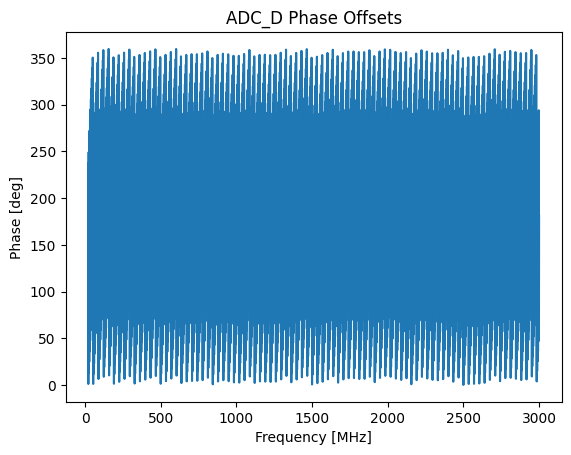

In [11]:
x, y = [], []
for key, value in adc_d_offsets.items():
    x.append(key)
    y.append(value)

plt.plot(x, y)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Phase [deg]")
plt.title("ADC_D Phase Offsets");

## ADC_C

In [18]:
config['reps'] = 1000 # change this from 10 to 1000
config['soft_avgs'] = 1
adc_c_offsets = {}

for f0 in f0_v:
    config['pulse_freq'] = f0
    prog =SingleFreqProgram(soccfg, config)
    avg_data = prog.acquire(soc, progress=False)
    data = [[prog.di_buf[i]/config['readout_length'], prog.dq_buf[i]/config['readout_length']] for i in range(2)]
    adc_c_offsets[f0] = ([calculate_phase(d) for d in data])[1]
soc.reset_gens()

print(adc_c_offsets)

{21.000002288818358: 236.14335862013064, 21.999998474121092: 0.23162161450972008, 22.999994659423827: 124.28105224482363, 23.99999084472656: 248.2922071503413, 25.000007629394528: 11.954157784151391, 26.000003814697262: 135.9051220446666, 26.999999999999996: 259.83012453217526, 27.99999618530273: 23.731958033783314, 28.999992370605465: 147.61570279589807, 30.000009155273435: 271.1642665873209, 31.00000534057617: 35.01286831870118, 32.0000015258789: 158.84745295970868, 32.999997711181635: 282.66876655324927, 33.99999389648437: 46.47893479796613, 34.999990081787104: 170.27984884910052, 36.000006866455074: 293.75405571874927, 37.00000305175781: 57.53376622592219, 37.99999923706054: 181.30559813916744, 38.99999542236328: 305.07115255839153, 39.99999160766601: 68.82831948304431, 41.00000839233398: 192.26224299850247, 42.000004577636716: 316.00844992037247, 43.00000076293945: 79.74700003432332, 43.999996948242185: 203.4818295984989, 44.99999313354492: 327.2083298418059, 46.00000991821289: 90

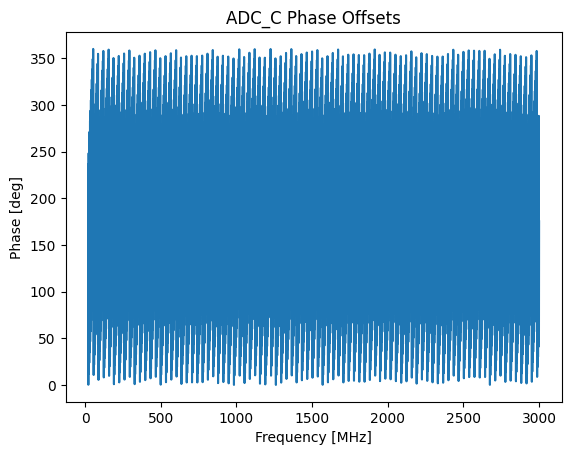

In [13]:
adc_c_x, adc_c_y = [], []
for key, value in adc_c_offsets.items():
    adc_c_x.append(key)
    adc_c_y.append(value)

plt.plot(adc_c_x,adc_c_y)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Phase [deg]")
plt.title("ADC_C Phase Offsets");

In [14]:
adc_offsets = {}

for freq in adc_c_offsets:
    adc_offsets[freq] = ((adc_c_offsets[freq] - adc_d_offsets[freq]) % 360) - 360

# print(adc_offsets)

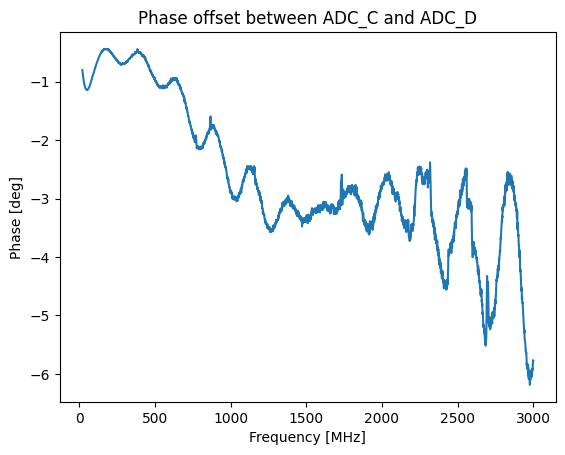

In [15]:
x,y = [], []
for key, value in adc_offsets.items():
    x.append(key)
    y.append(value)

plt.plot(x,y)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Phase [deg]")
plt.title("Phase offset between ADC_C and ADC_D");

## Calibrate Phase

In [19]:
config['reps'] = 1000 # change this from 10 to 1000
config['soft_avgs'] = 1
delta_phis = {}

for f0 in f0_v:
    config['pulse_freq'] = f0
    prog =SingleFreqProgram(soccfg, config)
    avg_data = prog.acquire(soc, progress=False)
    data = [[prog.di_buf[i]/config['readout_length'], prog.dq_buf[i]/config['readout_length']] for i in range(2)]
    phis = [calculate_phase(d) for d in data]
    delta_phis[f0] = [(phis[0] - phis[1] + adc_offsets[f0]) % 360, 0]
    # print_results(res[-1])
soc.reset_gens()

# print(res)
# adc_c_phi = res[0][1][0]
# adc_d_phi = res[0][0][0]
# adc_d_phi_corrected = adc_d_phi + adc_offset
# delta_phi = (adc_c_phi - adc_d_phi_corrected) % 360
# print(delta_phi)
print(delta_phis)

{21.000002288818358: [106.58029378863529, 0], 21.999998474121092: [94.49940104481817, 0], 22.999994659423827: [82.42000979663194, 0], 23.99999084472656: [70.33952706037536, 0], 25.000007629394528: [58.25815610395034, 0], 26.000003814697262: [46.17748237752366, 0], 26.999999999999996: [34.0975342456569, 0], 27.99999618530273: [22.016492837041596, 0], 28.999992370605465: [9.936220379597046, 0], 30.000009155273435: [357.8548485867571, 0], 31.00000534057617: [345.7727505436107, 0], 32.0000015258789: [333.6906215739783, 0], 32.999997711181635: [321.6068663003761, 0], 33.99999389648437: [309.52551862165984, 0], 34.999990081787104: [297.4419002594343, 0], 36.000006866455074: [285.35819490852145, 0], 37.00000305175781: [273.2755327130652, 0], 37.99999923706054: [261.19340660394136, 0], 38.99999542236328: [249.1075636694969, 0], 39.99999160766601: [237.0243102096626, 0], 41.00000839233398: [224.94032438428533, 0], 42.000004577636716: [212.854477749941, 0], 43.00000076293945: [200.7695717130573,

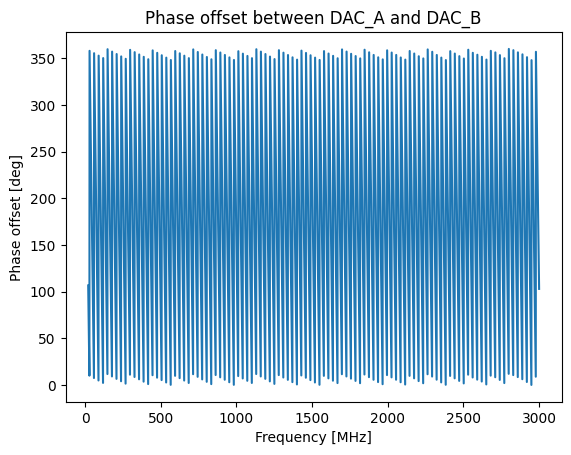

In [17]:
x,y = [], []
for key, value in delta_phis.items():
    x.append(key)
    y.append(value[0])

plt.plot(x,y)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Phase offset [deg]")
plt.title("Phase offset between DAC_A and DAC_B");

In [15]:
# to save the data
with open('pickles/calibrate_phase.pickle', 'wb') as handle:
    pickle.dump(delta_phis, handle, protocol=pickle.HIGHEST_PROTOCOL)